## PHYS 366 Final Project
---
#### Sean McLaughlin

In this project I will attempt to infer the Mass-Richness relation for Galaxy clusters. I will begin by building a model and a functional relationship amongst the parmaters. After, I will generate some mock data and compare it to some real data I have access to. If that is all successful, I will infer the parameters with MCMC. 

## The Model
---

### Basics
---

The richness of a galaxy cluster (a measure of how populated the cluster is) is related to the mass of the cluster's halo by the assumed relation:

$\lambda(a,b)  = a M^b+\sigma$

Where $\sigma$ is some insofar undefined intrinsic scatter. We will most likely try a lognormal relation, but there are other options to try. Our only data in this example is a collection of observed richnesses. We also have redshifts, which in a more complex model would be observed, but in this base case we will assume is given. 

The dark matter mass (obviously) cannot be observed. However, the mass function gives us a distribution of masses given only a redshift and cosmological information. The mass function will have to be carefully chosen.


### PGM
---
This model has the following PGM.

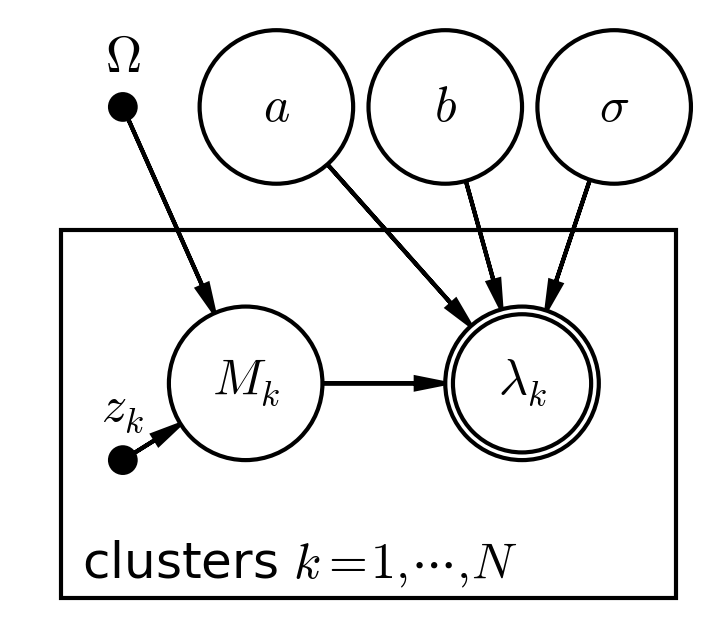

In [2]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,.85,fixed =True))
#pgm.add_node(daft.Node("class", r"$c_k$", 0.7, 1.35, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_edge("redshift", "Mcluster")
#pgm.add_edge("class", "Mcluster")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM2.png", dpi = 300)
from IPython.display import Image
Image("modelPGM2.png")

This model reveals a few assumptions that have been made. I've assumed that in addition to the individual cluster redshifts being fixed, the cosmology $\Omega$ is also fixed. We could unfix it and choose to infer both the relation parameters and and the cosmology, or fix the parameters to focus just on the cosmology. Those options will be revisited later. We've also assumed at this point that all richnesses have been observed perfectly. Measrement error and/or shot noise will have to be added in as well. 

This PGM decomposes to the distribution:

$P(a,b,\sigma |\; \Omega, \{z\}, \{\lambda\}) = \int{\prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma) \; P(M_k |\; z_k, \Omega)\; P(a,b,\sigma)\; dM_k}} $

Out of the gate it's easy to see the most challenging part will be the N-dimensional integral of all the cluster masses. 

### Individual distributions
-----

These will have to be revisited, possibly several times to get them right. I'll start as simple as I can and build forward from there. 

$P(\lambda_k |\; M_k, a,b,\sigma)$:

I'll assume deviations from the main relation are lognormally distributed. So, 

$\mathcal{l} \;(\lambda_k | \; M_k, a,b,\sigma)  = \frac{-(\mu-\log(\lambda_k))^2}{2\;\sigma^2}-\log(\sigma \; \lambda_k)-\log(\sqrt{2\pi}) $

With $\mu$ defined as:

$\mu = \log(a M_k ^ b) = b\;\log(a M_k) $

-----
$P(M_k |\; z_k, \Omega)$: 

### TODO

----

$P(a,b,\sigma)$:
I wrote the prior on parameters above together for notationaly simplicity. However, they will each be independant, so deconstruct to:

$P(a)\;P(b)\;P(\sigma)$

For $a$, we know little except that it must be greater than 0 since there can be know negative richness. Since in the log-log plot $\log{a}$ is the intercept of the "line", so we can think about how we would want that to be distributed. A uniform distribution on $\log{a}$ may be a good idea. However , that will acutally probably bias $a$ to exponentially large values. Better instead may be an exponential in $\log(a)$ which would be approximatley uniform in $a$. This has one hyperparameter to tune, $\lambda$. 

$\mathcal{l}(\log{a}) = \log{\lambda} - \lambda \log{a}$

For $b$, we know about the same. Physically, we know it must be greater than 0. On a log-log plot, $b$ is the slope of the line of best fit. Then, perhaps distribution that favors all angles of that line equally will be a good choice. So, we'll define

$b \equiv \tan(\theta)$

And insist $\theta \thicksim U(0, \frac{\pi}{2})$ such that

$\mathcal{l}(\theta) = \log(\frac{2}{\pi})$

Lastly, is the prior for $\sigma$. We have a few choices here. $\sigma$ needs to be invariant to scaling, so $\mathcal{l} \propto 1/\sigma$ is a good choice. However, since that is an improper prior there may be trouble later. Another choice is the inverse gamma distribution. It is the conjugate prior for the log-Normal distribution. It has 2 hyper parameters $\alpha$ and $\beta$, which is a lot to tune. For now, I'll go with the gamma because the additional tuning may help me find the right scatter for my mock data. If tuning is an issue later I will return with a simpler prior. I'll also see if I can make use of the conjugate properties. 

$\mathcal{l}(\sigma) = \log{\Gamma(\alpha, \beta)} $